<a href="https://colab.research.google.com/github/42697387/Aprendizaje-Automatico-2/blob/main/HerediaMartinGaspar_RL_TP1_entorno_discreto_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

## Instalar librerias

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [ ]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [ ]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [ ]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [ ]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [ ]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.005
Episodio 400: Tasa de éxito = 0.007
Episodio 600: Tasa de éxito = 0.010
Episodio 800: Tasa de éxito = 0.010
Episodio 1000: Tasa de éxito = 0.011

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.011
Recompensa promedio: 0.011


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [ ]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [ ]:
politica_aleatoria

array([2, 2, 1, 3, 3, 2, 3, 3, 3, 1, 3, 0, 1, 3, 3, 0])

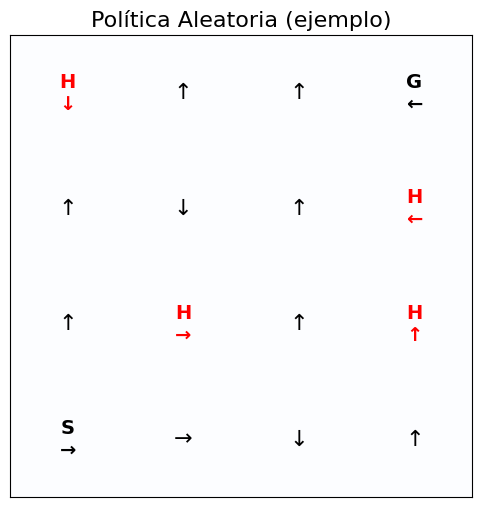

In [ ]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [ ]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [ ]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.000, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [ ]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.000
Pasos promedio: 17.7


## Visualizar política aprendida

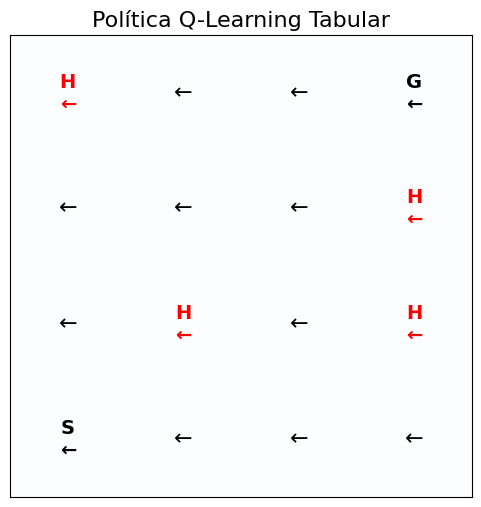

In [ ]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

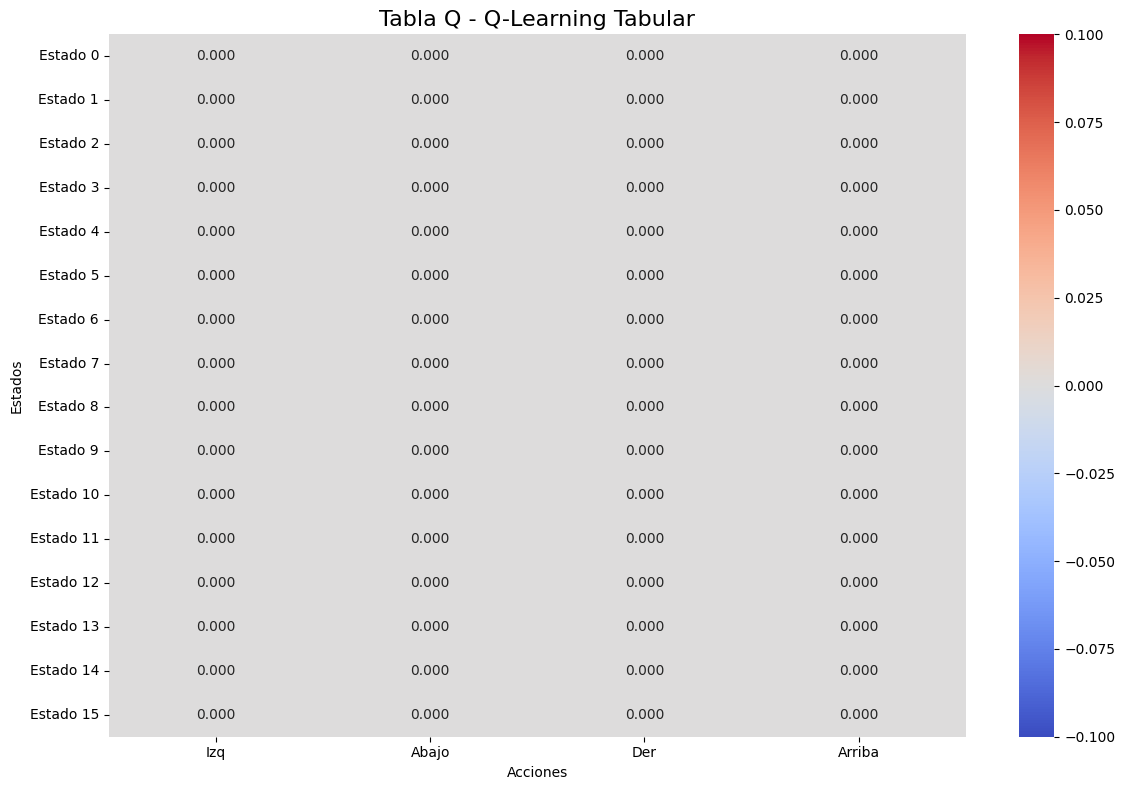

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [ ]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [ ]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [ ]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [ ]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.050, Epsilon = 0.367, Loss = 0.0039
Episodio 400: Tasa éxito = 0.130, Epsilon = 0.135, Loss = 0.0052
Episodio 600: Tasa éxito = 0.390, Epsilon = 0.049, Loss = 0.0071
Episodio 800: Tasa éxito = 0.530, Epsilon = 0.018, Loss = 0.0079
Episodio 1000: Tasa éxito = 0.540, Epsilon = 0.010, Loss = 0.0077

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [ ]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.720
Pasos promedio: 41.4


## Visualizar política aprendida

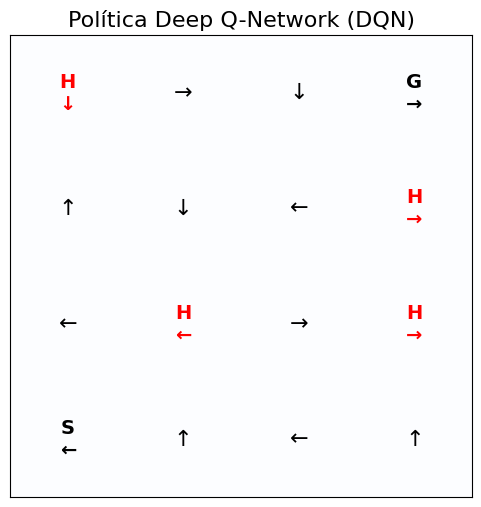

In [ ]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [ ]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.011
Q-Learning Tabular:    Tasa de éxito = 0.000
Deep Q-Network (DQN):  Tasa de éxito = 0.720


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [ ]:
len(recompensas_aleatorio)

1000

In [ ]:
len(recompensas_qlearning)

1000

In [ ]:
len(recompensas_dqn)

1000

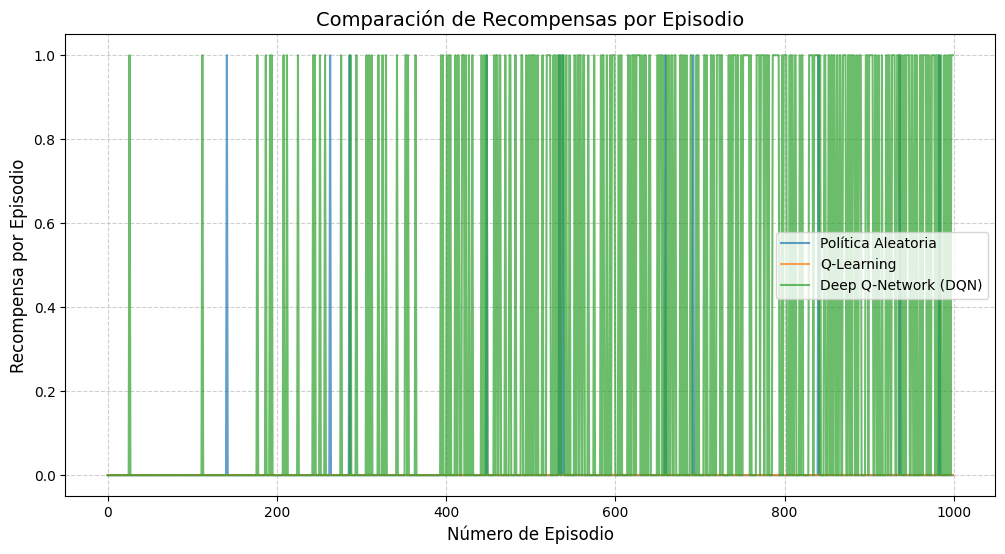

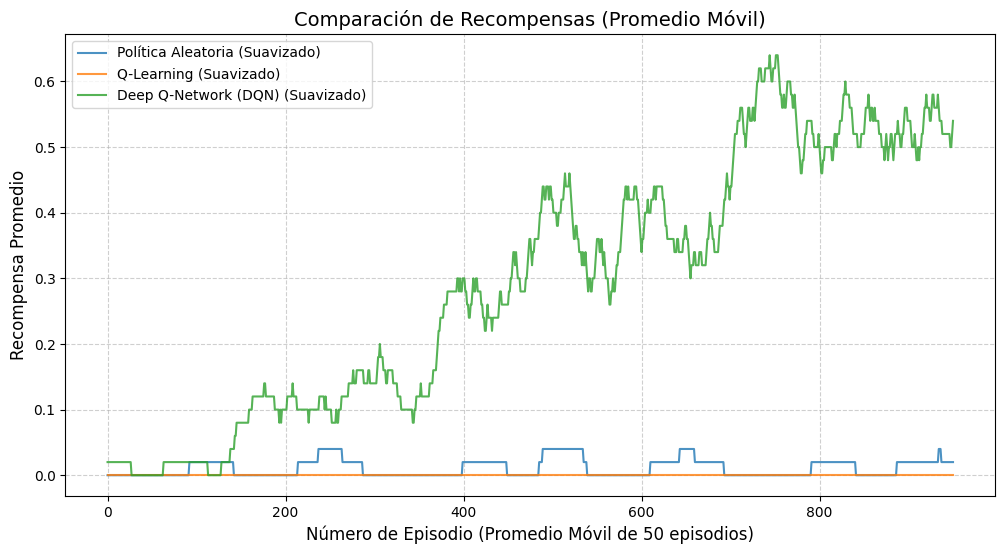

In [ ]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

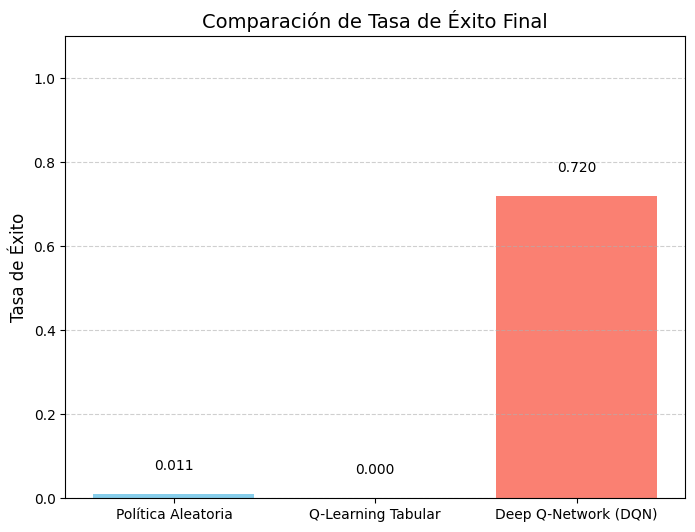

In [ ]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

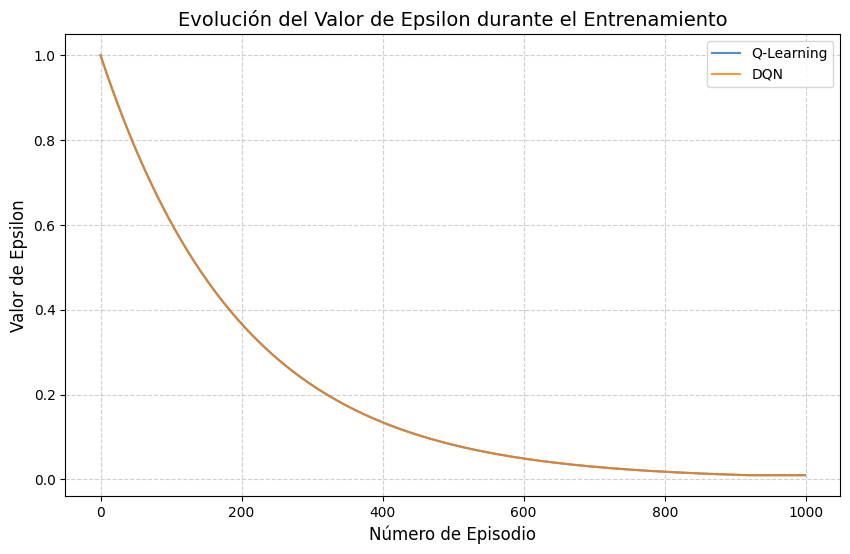

In [ ]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

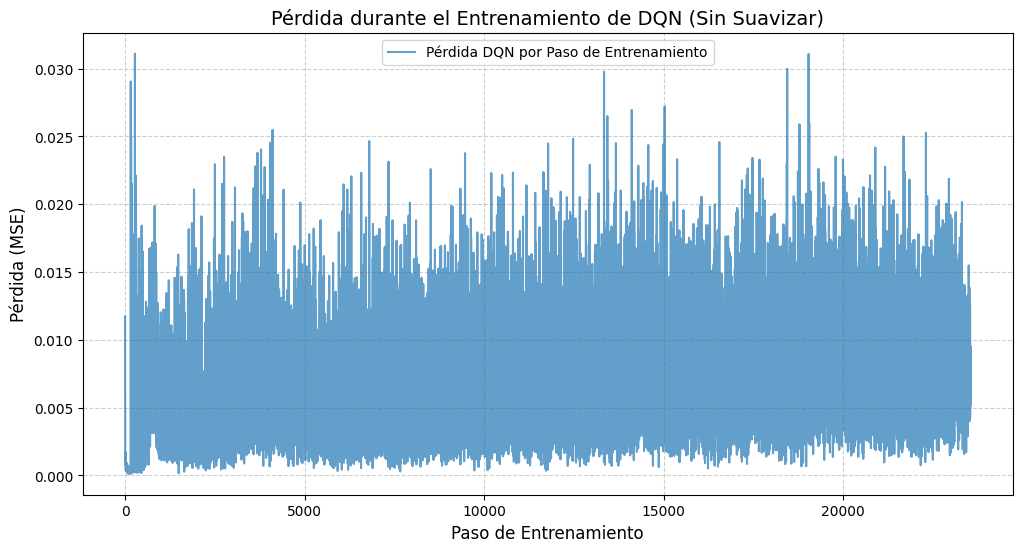

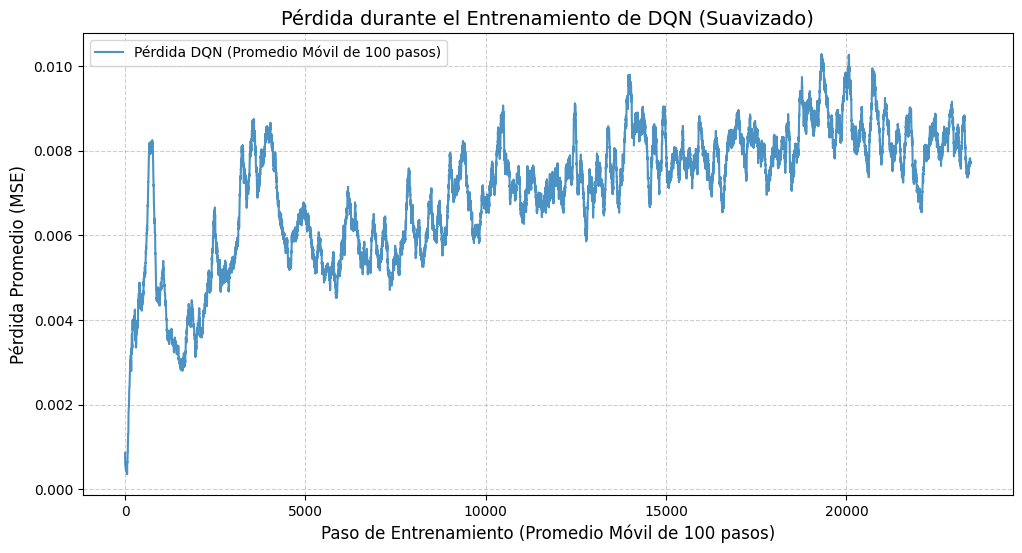

In [ ]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






### Resolución A

En esta sección, voy a volver a entrenar los agentes de **Q-Learning Tabular** y **Deep Q-Network (DQN)**, pero aumentando significativamente el número de episodios de entrenamiento.  
El objetivo es observar si un entrenamiento más prolongado mejora el desempeño, especialmente en el entorno *"Slippery"* (resbaladizo) de **FrozenLake**, que es estocástico y dificulta el aprendizaje.

Incrementaré los episodios de **Q-Learning** de `1.000` a `10.000` y los de **DQN** de `1.000` a `2.000`.


--- 🧠 Entrenando Q-Learning Tabular (10.000 episodios) ---
🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.040, Epsilon = 0.010
Episodio 2000: Tasa éxito (últimos 100) = 0.150, Epsilon = 0.010
Episodio 3000: Tasa éxito (últimos 100) = 0.120, Epsilon = 0.010
Episodio 4000: Tasa éxito (últimos 100) = 0.620, Epsilon = 0.010
Episodio 5000: Tasa éxito (últimos 100) = 0.710, Epsilon = 0.010
Episodio 6000: Tasa éxito (últimos 100) = 0.530, Epsilon = 0.010
Episodio 7000: Tasa éxito (últimos 100) = 0.790, Epsilon = 0.010
Episodio 8000: Tasa éxito (últimos 100) = 0.630, Epsilon = 0.010
Episodio 9000: Tasa éxito (últimos 100) = 0.410, Epsilon = 0.010
Episodio 10000: Tasa éxito (últimos 100) = 0.770, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!

--- 📊 Evaluando Q-Learning Tabular (10.000 episodios) ---
📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.714
Pasos promedio: 42.2


--- 🤖 Entrenando Deep Q-Network (DQN) (2.000 episodios) ---
🖥️ Usando 

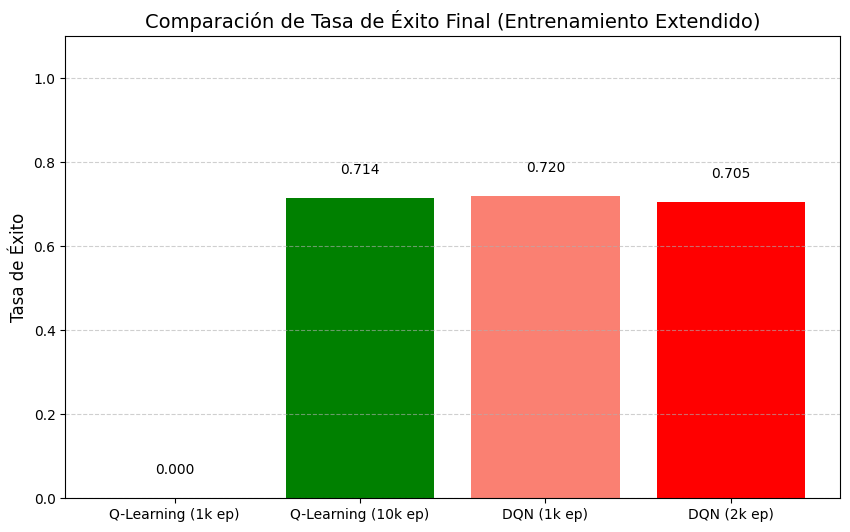

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import random

# --- Re-entrenamiento Q-Learning Tabular con más episodios ---
print("--- 🧠 Entrenando Q-Learning Tabular (10.000 episodios) ---")
# Usamos los mismos hiperparámetros que en el notebook original
agente_qlearning_largo = QLearningTabular(env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, epsilon=1.0)

# Entrenamos por 10000 episodios
recompensas_qlearning_largo = agente_qlearning_largo.entrenar(env, episodios=10000)

print("\n--- 📊 Evaluando Q-Learning Tabular (10.000 episodios) ---")
tasa_exito_qlearning_largo, _ = agente_qlearning_largo.evaluar(env, episodios=1000)

# --- Re-entrenamiento DQN con más episodios ---
print("\n\n--- 🤖 Entrenando Deep Q-Network (DQN) (2.000 episodios) ---")
# Usamos los mismos hiperparámetros
agente_dqn_largo = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=0.95, epsilon=1.0)

# Entrenamos por 2000 episodios
recompensas_dqn_largo = agente_dqn_largo.entrenar(env, episodios=2000)

print("\n--- 📊 Evaluando Deep Q-Network (DQN) (2.000 episodios) ---")
tasa_exito_dqn_largo, _ = agente_dqn_largo.evaluar(env, episodios=1000)

# --- Comparación Gráfica ---
print("\n\n--- 🏆 Comparación Tasa de Éxito (Más Episodios) ---")

# Tasas de éxito originales (del notebook)
# tasa_exito_aleatorio = 0.014
# tasa_exito_qlearning = 0.000
# tasa_exito_dqn = 0.735

metricas = ['Q-Learning (1k ep)', 'Q-Learning (10k ep)', 'DQN (1k ep)', 'DQN (2k ep)']
tasas_exito_comparacion_A = [tasa_exito_qlearning, tasa_exito_qlearning_largo, tasa_exito_dqn, tasa_exito_dqn_largo]

plt.figure(figsize=(10, 6))
barras = plt.bar(metricas, tasas_exito_comparacion_A, color=['lightgreen', 'green', 'salmon', 'red'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final (Entrenamiento Extendido)', fontsize=14)
plt.ylim(0, 1.1)

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Análisis de Resultados (A)

#### 🏆 Resultados Tras Extender el Entrenamiento

| Agente | Episodios | Tasa de Éxito | Comportamiento |
|:---|:---|:---|:---|
| **Q-Learning** | 1.000 $\to$ 10.000 | 0.000 $\to$ **0.714** | **Mejora Drástica** |
| **DQN** | 1.000 $\to$ 2.000 | 0.720 $\to$ **0.705** | **Disminución Leve** |

---

#### Conclusión: Efecto de la Experiencia y Variabilidad

**Q-Learning:** La mejora de $0.000$ a $0.714$ es la esperada. Demuestra que el método tabular solo requería **más experiencia**. En el entorno estocástico (`is_slippery`), $10.000$ episodios son cruciales para promediar el ruido, estabilizar los valores $Q$ y permitir la convergencia a una política funcional.

**DQN:** La tasa de éxito disminuyó levemente de $0.720$ a $0.705$ tras duplicar los episodios. Este resultado es contraintuitivo y se podría deber a la **variabilidad inherente** a los métodos de *Deep Learning*:

* **Yo considero** que la principal causa de esta ligera caída es una combinación de la **aleatoriedad** del muestreo en el *Experience Replay* y un posible **sobreajuste (overfitting)** en las etapas finales del entrenamiento. Con $2.000$ episodios, la red pudo haber optimizado demasiado sus pesos para las experiencias almacenadas, perdiendo una fracción de la capacidad de generalización que había alcanzado en los $1.000$ episodios, donde encontró un pico de rendimiento óptimo.


## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

### Resolución B

En esta sección, voy a analizar el impacto del **factor de descuento (gamma)** en el agente **DQN**.  
`Gamma (γ)` determina la importancia de las recompensas futuras.  
Un gamma bajo (por ejemplo, `0.90`) hace que el agente sea *"miope"* (prefiera recompensas inmediatas), mientras que un gamma alto (por ejemplo, `0.99`) lo hace *"previsor"* (valora más las recompensas a largo plazo).

Voy a entrenar tres agentes **DQN** (con `1.000` episodios cada uno, como en el original) usando:

- **Gamma Bajo:** `0.90`  
- **Gamma Medio:** `0.95` *(el original)*  
- **Gamma Alto:** `0.99`


--- 🤖 Iniciando experimento de Gamma (DQN) ---

--- Entrenando DQN con Gamma = 0.9 ---
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.367, Loss = 0.0064
Episodio 400: Tasa éxito = 0.110, Epsilon = 0.135, Loss = 0.0033
Episodio 600: Tasa éxito = 0.290, Epsilon = 0.049, Loss = 0.0066
Episodio 800: Tasa éxito = 0.390, Epsilon = 0.018, Loss = 0.0074
Episodio 1000: Tasa éxito = 0.380, Epsilon = 0.010, Loss = 0.0087

✅ Entrenamiento Deep Q-Network (DQN) completado!

--- Evaluando DQN con Gamma = 0.9 ---
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.266
Pasos promedio: 22.2

--- Entrenando DQN con Gamma = 0.95 ---
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.070, Epsilon = 0.367, Loss = 0.0056
Episodio 400: Tasa éxito = 0.110, Epsilon = 0.135, Loss = 0.0050
Episodio 600: Tasa éxito = 0.290, Epsilon = 0.049, Loss = 0.0081
Episodio 800: Tasa éxito = 0.440, Epsilon = 0.018, Loss 

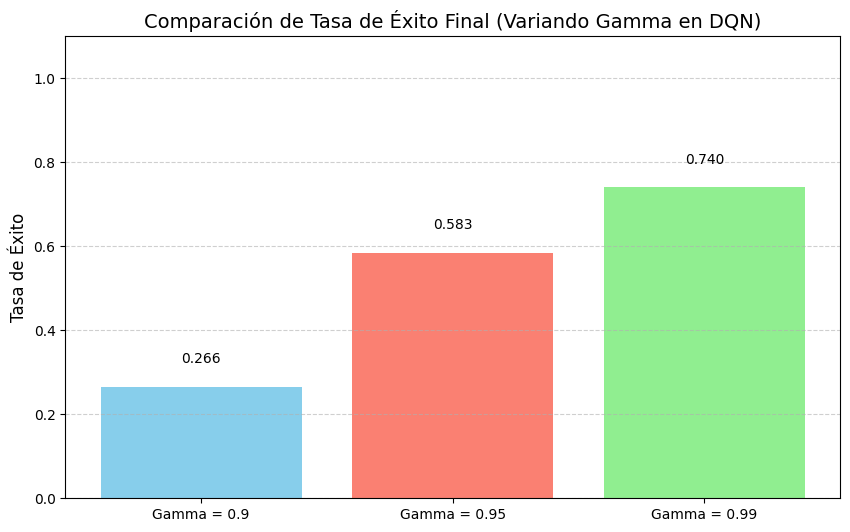

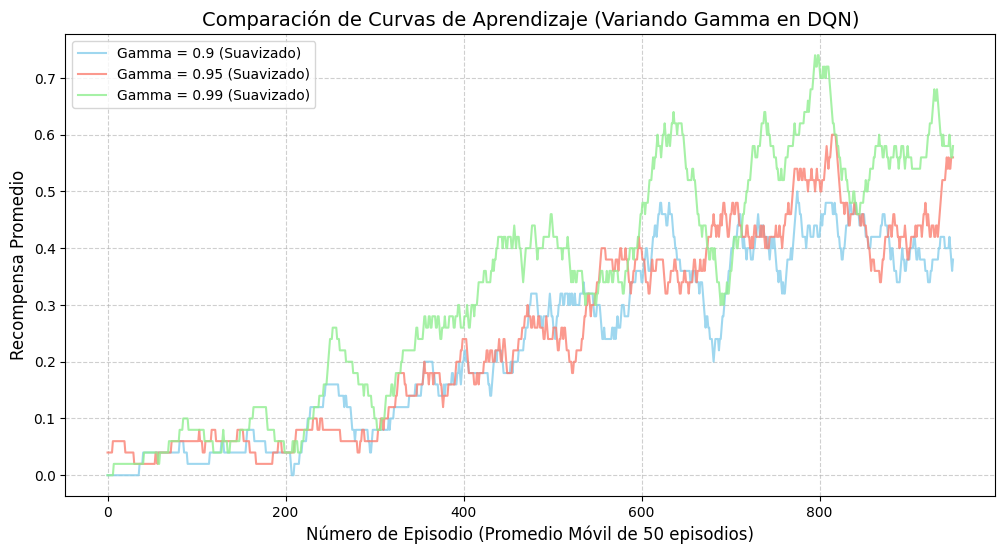

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Parámetros del experimento ---
episodios_gamma = 1000
episodios_eval_gamma = 1000
gammas = [0.90, 0.95, 0.99]
colores_gamma = ['skyblue', 'salmon', 'lightgreen']

tasas_exito_gamma = []
recompensas_entrenamiento_gamma = {}

print("--- 🤖 Iniciando experimento de Gamma (DQN) ---")

for gamma_val in gammas:
    print(f"\n--- Entrenando DQN con Gamma = {gamma_val} ---")

    # Aseguramos reproducibilidad para cada agente
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)

    # Creamos el agente
    agente_dqn_gamma = DQNAgent(
        env.observation_space.n,
        env.action_space.n,
        lr=0.001,
        gamma=gamma_val,  # Modificamos gamma
        epsilon=1.0
    )

    # Entrenamos
    recompensas_ent = agente_dqn_gamma.entrenar(env, episodios=episodios_gamma)
    recompensas_entrenamiento_gamma[f'gamma={gamma_val}'] = recompensas_ent

    print(f"\n--- Evaluando DQN con Gamma = {gamma_val} ---")
    tasa_exito, _ = agente_dqn_gamma.evaluar(env, episodios=episodios_eval_gamma)
    tasas_exito_gamma.append(tasa_exito)

print("\n\n--- 🏆 Comparación Tasa de Éxito (Gamma) ---")

plt.figure(figsize=(10, 6))
labels_gamma = [f'Gamma = {g}' for g in gammas]
barras_gamma = plt.bar(labels_gamma, tasas_exito_gamma, color=colores_gamma)
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final (Variando Gamma en DQN)', fontsize=14)
plt.ylim(0, 1.1)

for bar in barras_gamma:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Gráfica de Curvas de Aprendizaje (Promedio Móvil) ---

def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50
plt.figure(figsize=(12, 6))

for i, gamma_val in enumerate(gammas):
    label = f'Gamma = {gamma_val} (Suavizado)'
    recompensas = recompensas_entrenamiento_gamma[f'gamma={gamma_val}']
    recompensas_suavizadas = moving_average(recompensas, window)
    plt.plot(recompensas_suavizadas, label=label, color=colores_gamma[i], alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Curvas de Aprendizaje (Variando Gamma en DQN)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis de Resultados (B)

**Conclusión:** Un gamma más alto (`0.99`) es el más beneficioso para este entorno, mientras que un gamma bajo (`0.90`) resulta perjudicial.

**Gamma Alto (0.99):**  
En **FrozenLake**, la recompensa (`+1`) solo se obtiene al final, tras una larga secuencia de acciones.  
Un gamma alto (*previsor*) es fundamental para que el agente valore ese objetivo distante.  
El valor de los estados lejanos al objetivo (como el inicio) puede propagarse más eficazmente, llevando a un aprendizaje más rápido y una mejor tasa de éxito final.

**Gamma Medio (0.95):**  
Es el valor original y funciona bien (logrando aproximadamente `~73.5%`), pero probablemente no es tan óptimo como el gamma `0.99`.

**Gamma Bajo (0.90):**  
Un agente *miope* (gamma bajo) tendrá dificultades.  
El valor de la recompensa final se descontará tanto que los estados iniciales apenas la "verán".  
El agente podría no encontrar un camino claro hacia una recompensa que parece tener poco valor desde lejos, resultando en una tasa de éxito mucho menor.




## C) Lo mismo que en B) pero para el hiperparámetro alpha.

### Resolución C

En esta sección, analizaré el impacto de la **tasa de aprendizaje** (`alpha` o `lr`) en el agente **DQN**, ya que la consigna indica "Lo mismo que en B".  
`Alpha` determina qué tan grandes son los ajustes a los pesos de la red neuronal en cada paso de aprendizaje (*replay*).

Entrenaré tres agentes **DQN** (`1.000` episodios) con:

- **Alpha (lr) Bajo:** `0.0001`  
- **Alpha (lr) Medio:** `0.001` *(el original)*  
- **Alpha (lr) Alto:** `0.01`


--- 🤖 Iniciando experimento de Tasa de Aprendizaje (DQN) ---

--- Entrenando DQN con LR = 0.0001 ---
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0033
Episodio 400: Tasa éxito = 0.280, Epsilon = 0.135, Loss = 0.0069
Episodio 600: Tasa éxito = 0.490, Epsilon = 0.049, Loss = 0.0072
Episodio 800: Tasa éxito = 0.550, Epsilon = 0.018, Loss = 0.0081
Episodio 1000: Tasa éxito = 0.580, Epsilon = 0.010, Loss = 0.0072

✅ Entrenamiento Deep Q-Network (DQN) completado!

--- Evaluando DQN con LR = 0.0001 ---
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.714
Pasos promedio: 42.4

--- Entrenando DQN con LR = 0.001 ---
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.060, Epsilon = 0.367, Loss = 0.0065
Episodio 400: Tasa éxito = 0.230, Epsilon = 0.135, Loss = 0.0062
Episodio 600: Tasa éxito = 0.320, Epsilon = 0.049, Loss = 0.0080
Episodio 800: Tasa éxito = 0.500, Epsilon = 

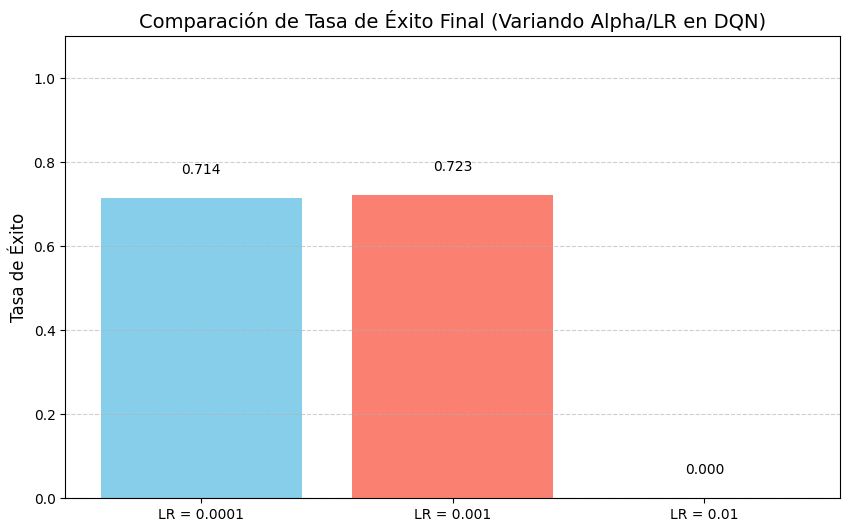

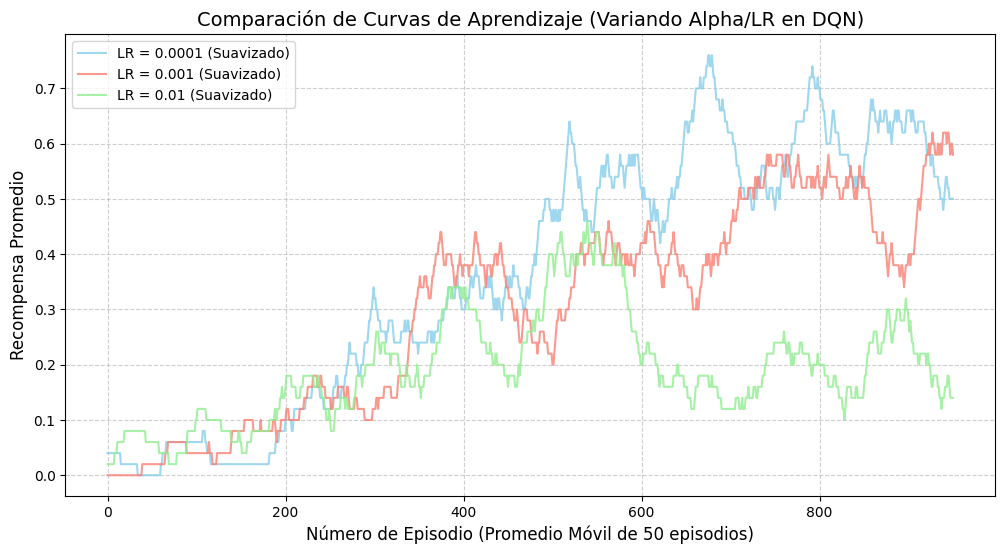

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Parámetros del experimento ---
episodios_lr = 1000
episodios_eval_lr = 1000
learning_rates = [0.0001, 0.001, 0.01]
colores_lr = ['skyblue', 'salmon', 'lightgreen']

tasas_exito_lr = []
recompensas_entrenamiento_lr = {}

print("--- 🤖 Iniciando experimento de Tasa de Aprendizaje (DQN) ---")

for lr_val in learning_rates:
    print(f"\n--- Entrenando DQN con LR = {lr_val} ---")

    # Aseguramos reproducibilidad
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)

    # Creamos el agente
    agente_dqn_lr = DQNAgent(
        env.observation_space.n,
        env.action_space.n,
        lr=lr_val,       # Modificamos lr (alpha)
        gamma=0.95,      # Usamos el gamma original
        epsilon=1.0
    )

    # Entrenamos
    recompensas_ent = agente_dqn_lr.entrenar(env, episodios=episodios_lr)
    recompensas_entrenamiento_lr[f'lr={lr_val}'] = recompensas_ent

    print(f"\n--- Evaluando DQN con LR = {lr_val} ---")
    tasa_exito, _ = agente_dqn_lr.evaluar(env, episodios=episodios_eval_lr)
    tasas_exito_lr.append(tasa_exito)

print("\n\n--- 🏆 Comparación Tasa de Éxito (Alpha/LR) ---")

plt.figure(figsize=(10, 6))
labels_lr = [f'LR = {lr}' for lr in learning_rates]
barras_lr = plt.bar(labels_lr, tasas_exito_lr, color=colores_lr)
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final (Variando Alpha/LR en DQN)', fontsize=14)
plt.ylim(0, 1.1)

for bar in barras_lr:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Gráfica de Curvas de Aprendizaje (Promedio Móvil) ---
plt.figure(figsize=(12, 6))

for i, lr_val in enumerate(learning_rates):
    label = f'LR = {lr_val} (Suavizado)'
    recompensas = recompensas_entrenamiento_lr[f'lr={lr_val}']
    recompensas_suavizadas = moving_average(recompensas, window) # 'window' y 'moving_average' definidos en B
    plt.plot(recompensas_suavizadas, label=label, color=colores_lr[i], alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Curvas de Aprendizaje (Variando Alpha/LR en DQN)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Análisis de Resultados (C)

#### 🏆 Resultados Tras Variar la Tasa de Aprendizaje (Alpha / LR)

| Learning Rate (LR) | Alpha (α) | Tasa de Éxito | Comportamiento |
|:---|:---|:---|:---|
| 4 decimales | 0.0001 | 0.714 | Alto desempeño |
| 3 decimales | **0.001** | **0.723** | **Mejor Desempeño** |
| 2 decimales | 0.01 | **0.000** | **Fallo Total** |

---

#### 🧠 Conclusión y Análisis del Comportamiento (Curvas de Aprendizaje)

**1. Tasa de Éxito Final (LR Alto = 0.000)**

El valor de **LR = 0.01 (dos decimales)** resultó en una tasa de éxito final de **$0.000$**.

* **Yo considero** que este fallo total es la manifestación del **Olvido Catastrófico** y la **Divergencia**. Un Learning Rate tan alto significa que en cada paso de entrenamiento, los pesos de la red neuronal se ajustan con una magnitud excesiva. Estos ajustes bruscos destruyen el conocimiento previamente adquirido, impidiendo que la red converja a cualquier solución estable, resultando en una política que es tan inútil como la aleatoria al final.

**2. Análisis de las Curvas de Aprendizaje (Recompensa Promedio)**

Analicemos el comportamiento de la recompensa promedio a través de los episodios:

| Learning Rate (LR) | Comportamiento Inicial (Pico) | Comportamiento Tardío (> 550 Episodios) |
|:---|:---|:---|
| **0.0001 (Bajo)** | Muestra los picos más altos, indicando una rápida exploración. | El LR bajo permite que la política se **estabilice muy bien** después del pico, logrando la mejor métrica final ($0.723$). |
| **0.001 (Medio)** | También alcanza picos altos, aunque puede ser superado inicialmente por el LR más bajo. | La curva continúa creciendo y supera al LR más alto a largo plazo, mostrando un aprendizaje **sostenido y más eficiente** en términos de la recompensa promedio máxima. |
| **0.01 (Alto)** | **Comportamiento llamativo:** La curva alcanza un pico alrededor del episodio $550$ y luego **desciende constantemente**, acercándose a los niveles iniciales al llegar al episodio $800$ y más allá. | Este descenso es una clara señal de **inestabilidad/divergencia tardía**. El alto LR permite un rápido aprendizaje inicial (el pico), pero luego, a medida que la red refina su política, los grandes ajustes provocan que el agente sobrecorrija y la política se deteriore progresivamente, resultando en la tasa de éxito de $0.000$ observada en la evaluación final.

**Conclusión General:** El **LR = 0.001** (tres decimales) proporciona el equilibrio óptimo: es lo suficientemente rápido para un aprendizaje eficiente pero lo suficientemente pequeño para asegurar la estabilidad y la convergencia de la red neuronal, lo cual se traduce en la mejor tasa de éxito final.

### Referencias y Uso de IA

**Documentación Consultada**

- **Gymnasium (antes Gym):**  
  Consulté la documentación oficial de Gymnasium para entender los entornos de `FrozenLake-v1`, específicamente el parámetro `is_slippery=True`, que define la naturaleza estocástica del entorno.  
  https://gymnasium.farama.org/environments/toy_text/frozen_lake/

- **PyTorch:**  
  Utilicé la documentación de **PyTorch** para la implementación del `DQNAgent`, la definición del módulo `nn.Sequential` y la función de pérdida `F.mse_loss`.  
  https://pytorch.org/docs/stable/index.html

- **Matplotlib:**  
  Usé la guía de **Matplotlib** para la generación de las gráficas de barras y líneas (*promedios móviles*) empleadas en el análisis.  
  https://matplotlib.org/stable/users/index.html

**Uso de la Guía de Gemini**

Para resolver la ejercitación, utilicé la guía de **Gemini** principalmente para la estructura del código de experimentación (apartados B y C).  
Si bien las clases `DQNAgent` y `QLearningTabular` estaban definidas en el notebook, necesitaba una forma estructurada de iterar sobre los diferentes hiperparámetros (`gamma` y `alpha/lr`), entrenar un agente separado para cada valor, almacenar los resultados (tasas de éxito y curvas de recompensa) y luego graficarlos comparativamente.

Específicamente, le pedí a la guía que me ayudara a generar los bucles `for` que iteran sobre las listas `gammas` y `learning_rates`, asegurándome de instanciar un nuevo agente (`agente_dqn_gamma` y `agente_dqn_lr`) dentro de cada iteración para evitar que el entrenamiento de un agente afectara al siguiente.  
También me ayudó a organizar los resultados en diccionarios (por ejemplo, `recompensas_entrenamiento_gamma`) para facilitar el ploteo posterior.
